In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats
from scipy.stats import zscore
from math import radians, cos, sin, asin, sqrt
import pydot
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models
import os, shutil
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
!pip install category_encoders
import category_encoders as ce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

     |████████████████████████████████| 86 kB 4.0 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# load in data 
url = 'https://raw.githubusercontent.com/rindalafayyad17/263-Project/main/diabetes_012_health_indicators_BRFSS2015.csv'
diabetes = pd.read_csv(url)


In [4]:
diabetes.shape

(253680, 22)

In [5]:
diabetes['Diabetes_012'].value_counts()

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes_012, dtype: int64

In [6]:
diabetes.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


We will need several preprocessing steps: 

0. Remove missing rows. We have tons of data so lets just try to drop any rows with NA values. **Turns out there are no missing values**

1. Identify the continuous and catgeorical variables. 

2. Continuous vairables need to be normalized, that is subtract mean and divide by standard deviation. Look at SCM class notes for assistance as sklearn should have package to do this. '

3. Categorical variables will need to be encoded appropriately. 

Continuous variables: 
- BMI, MentHlth, PhysHlth


Categorical Variables:

*Binary:* 
- HighBp, HighCl, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsumption, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex

*Ordinal*

- Age, Education, Income

In [7]:
#using category encoders instead
ce_OHE = ce.OneHotEncoder(cols=['Age','Education', 'Income'])

diabetes_final = ce_OHE.fit_transform(diabetes)
print(diabetes_final.head())
diabetes_final.shape

   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  Education_5  Education_6  \
0                   0.0           0.0     0.0  ...            0            0   
1                   0.0           1.0     0.0  ...            0            0   
2                   0.0           0.0     1.0  ...            0            0   
3                   0.0           1.0     1.0  ...            0            0   
4                   0.0           1.0     1.0  ...            0            0   

   Income_1  Income_2  Income_3  Income_4  Income_5  Income_6  Income_7  \
0         1         0  

(253680, 46)

In [8]:
# need to make training, validation and test split
features = diabetes_final.drop('Diabetes_012', axis = 1)

# reshape labels and encode them
ce_OHE = ce.OneHotEncoder(cols=['Diabetes_012'])
labels = ce_OHE.fit_transform(diabetes_final)
labels = labels.iloc[:,0:3]

In [9]:
# split into training and testing set 
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(features, labels,
    test_size=0.2, shuffle = True, random_state = 356)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 356) # 0.25 x 0.8 = 0.2

In [10]:
labels.head()

,Diabetes_012_1,Diabetes_012_2,Diabetes_012_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [11]:
features.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Education_5,Education_6,Income_1,Income_2,Income_3,Income_4,Income_5,Income_6,Income_7,Income_8
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
# build and compile model 
# Define model
model = keras.Sequential([
  layers.Dense(128, activation='relu', input_dim = 45),
  
  layers.Dense(64, activation='sigmoid'), 
  layers.Dropout(0.5),

  layers.Dense(32, activation='sigmoid'), 

  layers.Dense(3, activation='softmax') # 3 categories
])

# model compile function
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, 
          y_train, 
          epochs = 200, #change epochs to 100 after testing
          batch_size = 50,
          validation_data=(X_val, y_val)
          )

Epoch 1/200
3045/3045 [==============================] - 18s 5ms/step - loss: 0.4189 - accuracy: 0.8436 - val_loss: 0.4139 - val_accuracy: 0.8458
Epoch 2/200
3045/3045 [==============================] - 13s 4ms/step - loss: 0.4059 - accuracy: 0.8453 - val_loss: 0.4008 - val_accuracy: 0.8479
Epoch 3/200
3045/3045 [==============================] - 9s 3ms/step - loss: 0.4040 - accuracy: 0.8461 - val_loss: 0.4059 - val_accuracy: 0.8416
Epoch 4/200
3045/3045 [==============================] - 7s 2ms/step - loss: 0.4041 - accuracy: 0.8459 - val_loss: 0.4046 - val_accuracy: 0.8499
Epoch 5/200
3045/3045 [==============================] - 7s 2ms/step - loss: 0.4068 - accuracy: 0.8466 - val_loss: 0.4079 - val_accuracy: 0.8454
Epoch 6/200
3045/3045 [==============================] - 7s 2ms/step - loss: 0.4083 - accuracy: 0.8467 - val_loss: 0.4042 - val_accuracy: 0.8463
Epoch 7/200
3045/3045 [==============================] - 7s 2ms/step - loss: 0.4079 - accuracy: 0.8459 - val_loss: 0.4043 - val_

In [32]:
# save model
model.save('Drive/diabetes.h5')

In [33]:
# load model 
new_model = tf.keras.models.load_model("Drive/diabetes.h5")

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5888      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 16,323
Trainable params: 16,323
Non-trainable params: 0
_________________________________________________________________


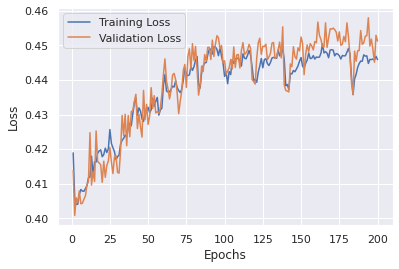

In [34]:
# plot of validation loss and train loss
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [35]:
# test set accuracy 
test_loss, test_acc = new_model.evaluate(X_test, y_test)
print("The test set accuracy is: ", test_acc)

1586/1586 [==============================] - 3s 2ms/step - loss: 0.4523 - accuracy: 0.8347
The test set accuracy is:  0.8346735835075378


#Next steps: 

**Modeling**
- normalize the continuous variables and rerun new model
- try different parameters (probably not epochs and batch size) such as units in hidden layers, depth of layers, activation functions

**Performance Evaluation**
- Create 3 by 3 accuracy table (done with reservations -- see below) 
- Subset data by income level and recreate accuracy tables


## WHY DOES MY ACCURACY ABOVE NOT MATCH CLASSIFCATION TABLE?

In [36]:
y_proba = new_model.predict(X_test) # need to make this into a vector again of [0,1,2] values and also make y_test back into vector of [0,1,2] 

In [37]:
y_pred = y_proba.argmax(axis = 1) # want 0,1,2 vector
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
y_proba


array([[0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235],
       ...,
       [0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235]], dtype=float32)

In [39]:
# need to y_test to be single vector of 0,1,2 again
y_test_lab = diabetes.iloc[y_test.index, :]["Diabetes_012"]

In [40]:
# create accuracy table 
#importing confusion matrix
confusion = confusion_matrix(y_test_lab, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_lab, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_lab, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_lab, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_lab, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_lab, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_lab, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_lab, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_lab, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_lab, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_lab, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test_lab, y_pred, target_names=['No diabetes', 'Prediabetes', 'Diabetes']))

Confusion Matrix

[[39729  2978     0]
 [  710   222     0]
 [ 4478  2619     0]]

Accuracy: 0.79

Micro Precision: 0.79
Micro Recall: 0.79
Micro F1-score: 0.79

Macro Precision: 0.31
Macro Recall: 0.39
Macro F1-score: 0.32

Weighted Precision: 0.75
Weighted Recall: 0.79
Weighted F1-score: 0.76

Classification Report



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr

              precision    recall  f1-score   support

 No diabetes       0.88      0.93      0.91     42707
 Prediabetes       0.04      0.24      0.07       932
    Diabetes       0.00      0.00      0.00      7097

    accuracy                           0.79     50736
   macro avg       0.31      0.39      0.32     50736
weighted avg       0.75      0.79      0.76     50736



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Subset the Data (Income) and Recalculate Accuracy

In [41]:
 # 8 is above $75,000, 5 is below 35,000
 # maybe start with split of below 5 and above 5 
diabetes['Income'].value_counts()

8.0    90385
7.0    43219
6.0    36470
5.0    25883
4.0    20135
3.0    15994
2.0    11783
1.0     9811
Name: Income, dtype: int64

In [42]:
# X test of only > 5 income 
X_test_high = X_test[(X_test["Income_6"] == 1.0) | (X_test["Income_7"] == 1.0) | (X_test["Income_8"] == 1.0)]
high_indx = X_test_high.index

# X test of only <= 5 income 
X_test_low = X_test[(X_test["Income_1"] == 1.0) | (X_test["Income_2"] == 1.0) | (X_test["Income_3"] == 1.0) | (X_test["Income_4"] == 1.0) | (X_test["Income_5"] == 1.0)]
low_indx = X_test_low.index


# y test of only same sebsets above
y_test_high = y_test[y_test.index.isin(high_indx)]
y_test_low = y_test[y_test.index.isin(low_indx)]

y_test_high

,Diabetes_012_1,Diabetes_012_2,Diabetes_012_3
204300,1,0,0
187954,1,0,0
205236,1,0,0
104585,1,0,0
113139,1,0,0
...,...,...,...
252276,1,0,0
94259,1,0,0
241228,1,0,0
62941,1,0,0


In [43]:
# high index accuracies 
y_proba_high = new_model.predict(X_test_high)

In [44]:
y_proba_high

array([[0.44508246, 0.5236197 , 0.03129789],
       [0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235],
       ...,
       [0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235],
       [0.88374066, 0.09905693, 0.01720235]], dtype=float32)

In [45]:
y_pred_high = y_proba_high.argmax(axis = 1) # want 0,1,2 vector
y_pred_high

array([1, 0, 0, ..., 0, 0, 0])

In [46]:
# need to y_test to be single vector of 0,1,2 again
y_test_lab_high = diabetes.iloc[y_test_high.index, :]['Diabetes_012']
y_test_lab_high

204300    0.0
187954    0.0
205236    0.0
104585    0.0
113139    0.0
         ... 
252276    0.0
94259     0.0
241228    0.0
62941     0.0
152849    0.0
Name: Diabetes_012, Length: 16133, dtype: float64

In [47]:
# create accuracy table 
#importing confusion matrix
confusion = confusion_matrix(y_test_lab_high, y_pred_high)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_lab_high, y_pred_high)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_lab_high, y_pred_high, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_lab_high, y_pred_high, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_lab_high, y_pred_high, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_lab_high, y_pred_high, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_lab_high, y_pred_high, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_lab_high, y_pred_high, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_lab_high, y_pred_high, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_lab_high, y_pred_high, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_lab_high, y_pred_high, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test_lab_high, y_pred_high, target_names=['No diabetes', 'Prediabetes', 'Diabetes']))

Confusion Matrix

[[12160  1063     0]
 [  244    80     0]
 [ 1612   974     0]]

Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.30
Macro Recall: 0.39
Macro F1-score: 0.32

Weighted Precision: 0.71
Weighted Recall: 0.76
Weighted F1-score: 0.73

Classification Report

              precision    recall  f1-score   support

 No diabetes       0.87      0.92      0.89     13223
 Prediabetes       0.04      0.25      0.07       324
    Diabetes       0.00      0.00      0.00      2586

    accuracy                           0.76     16133
   macro avg       0.30      0.39      0.32     16133
weighted avg       0.71      0.76      0.73     16133



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr

In [48]:
# repeat above for low 
# high index accuracies 
y_proba_low = new_model.predict(X_test_low)

y_pred_low = y_proba_low.argmax(axis = 1) # want 0,1,2 vector

# need to y_test to be single vector of 0,1,2 again
y_test_lab_low = diabetes.iloc[y_test_low.index, :]['Diabetes_012']
y_test_lab_low

193256    0.0
52416     0.0
125094    0.0
74892     0.0
1357      0.0
         ... 
87225     0.0
70127     0.0
78535     0.0
210913    2.0
72847     0.0
Name: Diabetes_012, Length: 34603, dtype: float64

In [49]:
# create accuracy table 
#importing confusion matrix
confusion = confusion_matrix(y_test_lab_low, y_pred_low)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_lab_low, y_pred_low)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_lab_low, y_pred_low, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_lab_low, y_pred_low, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_lab_low, y_pred_low, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_lab_low, y_pred_low, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_lab_low, y_pred_low, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_lab_low, y_pred_low, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_lab_low, y_pred_low, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_lab_low, y_pred_low, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_lab_low, y_pred_low, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test_lab_low, y_pred_low, target_names=['No diabetes', 'Prediabetes', 'Diabetes']))

Confusion Matrix

[[27569  1915     0]
 [  466   142     0]
 [ 2866  1645     0]]

Accuracy: 0.80

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.31
Macro Recall: 0.39
Macro F1-score: 0.33

Weighted Precision: 0.76
Weighted Recall: 0.80
Weighted F1-score: 0.78

Classification Report

              precision    recall  f1-score   support

 No diabetes       0.89      0.94      0.91     29484
 Prediabetes       0.04      0.23      0.07       608
    Diabetes       0.00      0.00      0.00      4511

    accuracy                           0.80     34603
   macro avg       0.31      0.39      0.33     34603
weighted avg       0.76      0.80      0.78     34603



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr